# Heart Disease Prediction with XGBoost

The information originates from the CDC (Centers for Disease Control and Prevention). To prepare and tidy the data, we used the pandas library in Python. Initially, we transformed the original dataset filetype from SAS to CSV format beforehand for preprocessing. We then carefully chose the variables that have a direct or indirect impact on heart disease.

In [91]:
!pip install xgboost
!pip install -U imbalanced-learn

In [92]:
import pandas as pd # linear algebra
import numpy as np # data processing, CSV file I/O
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

#Added file path of the CSV
df = pd.read_csv(r"./Post-DataProcessing/heart_no_nans.csv", encoding='utf-8')
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,26.57,No,No,No,0.0,0.0,No,Female,Age 80 or older,"White only, Non-Hispanic",No,No,Excellent,6.0,No,No,Yes
1,No,25.61,No,No,No,2.0,3.0,No,Female,Age 55 to 59,"White only, Non-Hispanic",No,Yes,Very good,5.0,No,No,Yes
2,No,21.77,No,Yes,No,2.0,0.0,No,Female,Age 40 to 44,"White only, Non-Hispanic",No,Yes,Fair,9.0,No,No,No
3,No,26.08,No,No,Yes,1.0,0.0,No,Male,Age 80 or older,"White only, Non-Hispanic",Yes,No,Poor,7.0,No,No,No
4,No,22.96,Yes,Yes,No,0.0,0.0,No,Female,Age 80 or older,"Black only, Non-Hispanic",No,Yes,Very good,7.0,No,No,No


In [93]:
print(f"{df.shape[0]} rows & {df.shape[1]} columns")

334321 rows & 18 columns


In [94]:
df.describe()

,BMI,PhysicalHealth,MentalHealth,SleepTime
count,334321.000000,334321.000000,334321.000000,334321.000000
mean,28.567086,4.185591,4.338088,7.024363
std,6.519035,8.473620,8.250558,1.449159
min,12.020000,0.000000,0.000000,1.000000
25%,24.160000,0.000000,0.000000,6.000000
50%,27.440000,0.000000,0.000000,7.000000
75%,31.750000,3.000000,5.000000,8.000000
max,97.650000,30.000000,30.000000,24.000000


In [95]:
cat_report = pd.DataFrame()
cat_list=['Smoking','AlcoholDrinking','Stroke','DiffWalking','Sex','AgeCategory','Race','Diabetic','PhysicalActivity','GenHealth','Asthma','KidneyDisease','SkinCancer']
len(cat_list)

13

In [96]:
def miss_count(column):
    return column.isnull().sum()

In [97]:
cont_list=['BMI', 'PhysicalHealth', 'MentalHealth','SleepTime']
dqr_cont = pd.DataFrame()
dqr_cont['Feature'] = cont_list
dqr_cont['Count'] = [i for i in df[cont_list].count()]
dqr_cont['% of Missing'] = [miss_count(df[i]) for i in cont_list] / dqr_cont['Count']
dqr_cont['Card'] = [i for i in df[cont_list].nunique()]
dqr_cont['Min'] = [i for i in df[cont_list].min()]
dqr_cont['Q1'] = [i for i in df[cont_list].quantile(q=0.25)]
dqr_cont['Median'] = [i for i in df[cont_list].quantile(q=0.50)]
dqr_cont['Q3'] = [i for i in df[cont_list].quantile(q=0.75)]
dqr_cont['Max'] = [i for i in df[cont_list].max()]
dqr_cont['Std'] = [i for i in df[cont_list].std()]
dqr_cont

,Feature,Count,% of Missing,Card,Min,Q1,Median,Q3,Max,Std
0,BMI,334321,0.0,3792,12.02,24.16,27.44,31.75,97.65,6.519035
1,PhysicalHealth,334321,0.0,31,0.00,0.00,0.00,3.00,30.00,8.473620
2,MentalHealth,334321,0.0,31,0.00,0.00,0.00,5.00,30.00,8.250558
3,SleepTime,334321,0.0,23,1.00,6.00,7.00,8.00,24.00,1.449159


/var/folders/5g/k3w_fwxs7y9ghhj9bf_7bp2c0000gn/T/ipykernel_96498/468128696.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["BMI"], bins=30,kde=False,hist_kws={"alpha":0.7})
/var/folders/5g/k3w_fwxs7y9ghhj9bf_7bp2c0000gn/T/ipykernel_96498/468128696.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sn

Text(0, 0.5, 'Count')

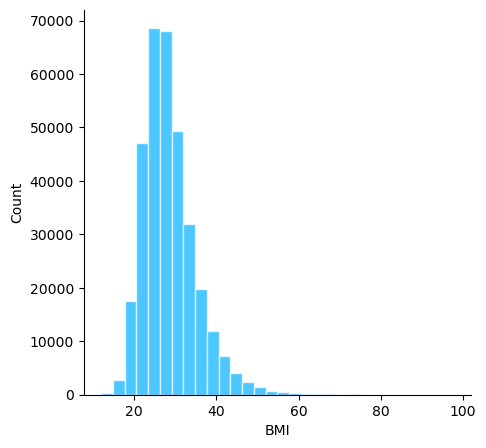

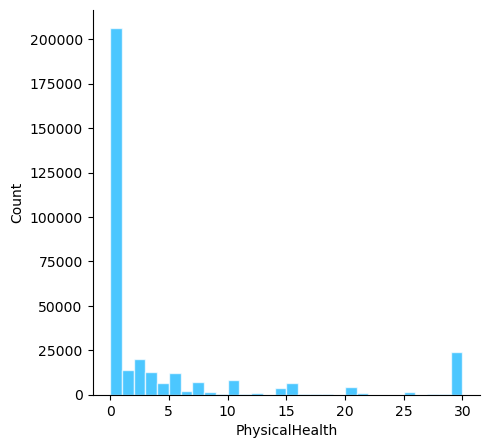

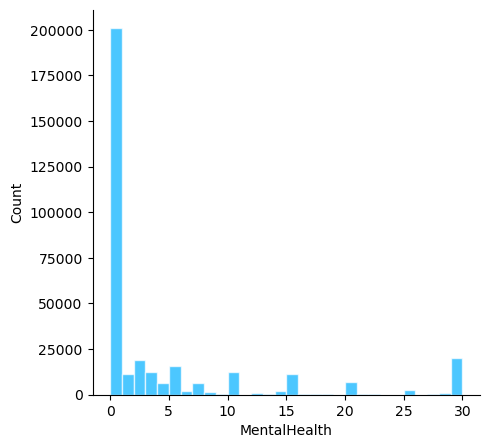

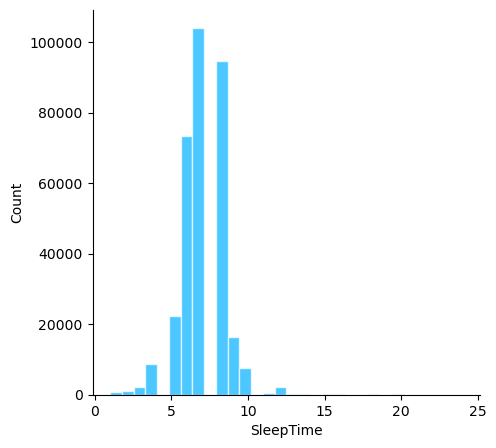

In [98]:
warnings.simplefilter(action='ignore', category=FutureWarning)
cont_list=['BMI', 'PhysicalHealth', 'MentalHealth','SleepTime']
plt.subplots(figsize=(5, 5))
sns.distplot(df["BMI"], bins=30,kde=False,hist_kws={"alpha":0.7})
plt.xlabel('BMI')
plt.ylabel('Count')
plt.subplots(figsize=(5, 5))
sns.distplot(df["PhysicalHealth"], bins=30,kde=False,hist_kws={"alpha":0.7})
plt.xlabel('PhysicalHealth')
plt.ylabel('Count')
plt.subplots(figsize=(5, 5))
sns.distplot(df["MentalHealth"], bins=30,kde=False,hist_kws={"alpha":0.7})
plt.xlabel('MentalHealth')
plt.ylabel('Count')
plt.subplots(figsize=(5, 5))
sns.distplot(df["SleepTime"], bins=30,kde=False,hist_kws={"alpha":0.7})
plt.xlabel('SleepTime')
plt.ylabel('Count')

<Axes: >

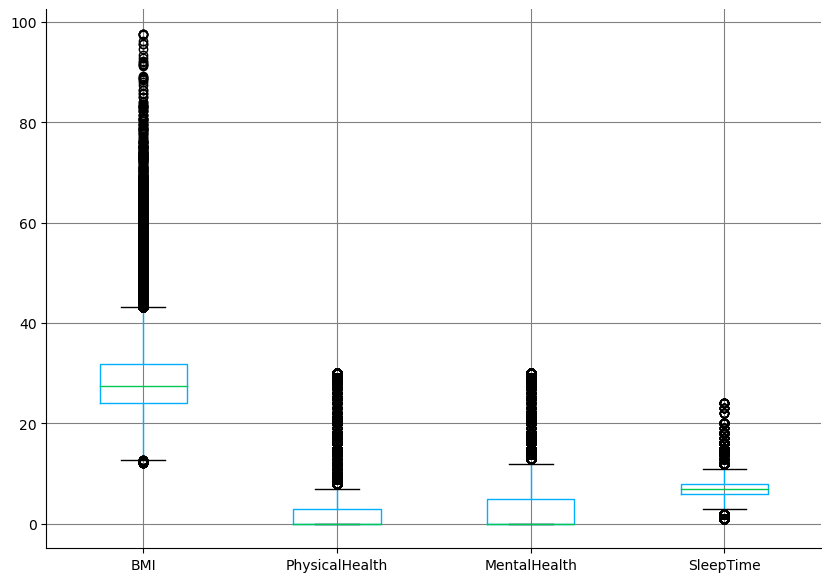

In [99]:
df.boxplot(column=cont_list, figsize=(10,7))

In [100]:
cont_list=['BMI', 'PhysicalHealth', 'MentalHealth','SleepTime']
Q1 = df['BMI'].quantile(0.25)
Q3 = df['BMI'].quantile(0.75)
IQR = Q3 - Q1
df_1 = df.loc[((df['BMI'] < (Q1 - 1.5 * IQR)) |(df['BMI'] > (Q3 + 1.5 * IQR)))]
out =df_1['BMI'].to_list()
df_cleaned = df.drop(df[df.BMI.isin(out)].index)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 323940 entries, 0 to 334320
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      323940 non-null  object 
 1   BMI               323940 non-null  float64
 2   Smoking           323940 non-null  object 
 3   AlcoholDrinking   323940 non-null  object 
 4   Stroke            323940 non-null  object 
 5   PhysicalHealth    323940 non-null  float64
 6   MentalHealth      323940 non-null  float64
 7   DiffWalking       323940 non-null  object 
 8   Sex               323940 non-null  object 
 9   AgeCategory       323940 non-null  object 
 10  Race              323940 non-null  object 
 11  Diabetic          323940 non-null  object 
 12  PhysicalActivity  323940 non-null  object 
 13  GenHealth         323940 non-null  object 
 14  SleepTime         323940 non-null  float64
 15  Asthma            323940 non-null  object 
 16  KidneyDisease     32

In [101]:
df_1['HeartDisease'].value_counts()

No     9616
Yes     765
Name: HeartDisease, dtype: int64

In [102]:
def get_mode(column_name,mode_order,get_val=True):
    return df[column_name].value_counts().to_list()[mode_order] if(get_val) else df[column_name].value_counts().index.to_list()[mode_order]
def mode_perc(column_name,mode_order):
    a = get_mode(column_name,mode_order)
    return round(100*a/df[column_name].count(),2)

Q1 = df['PhysicalHealth'].quantile(0.25)
Q3 = df['PhysicalHealth'].quantile(0.75)
IQR = Q3 - Q1
df_2 = df.loc[((df['PhysicalHealth'] < (Q1 - 1.5 * IQR)) |(df['PhysicalHealth'] > (Q3 + 1.5 * IQR)))]
df_2['HeartDisease'].value_counts()

No     46246
Yes     7252
Name: HeartDisease, dtype: int64

In [103]:
Q1 = df['MentalHealth'].quantile(0.25)
Q3 = df['MentalHealth'].quantile(0.75)
IQR = Q3 - Q1
df_3 = df.loc[((df['MentalHealth'] < (Q1 - 1.5 * IQR)) |(df['MentalHealth'] > (Q3 + 1.5 * IQR)))]
df_3['HeartDisease'].value_counts()

No     42135
Yes     3381
Name: HeartDisease, dtype: int64

In [104]:
df_3

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
12,No,32.28,Yes,No,No,0.0,15.0,Yes,Female,Age 80 or older,"White only, Non-Hispanic",Yes,Yes,Fair,6.0,Yes,No,Yes
22,Yes,22.14,Yes,No,No,0.0,20.0,No,Female,Age 65 to 69,"White only, Non-Hispanic",No,No,Good,8.0,No,Yes,No
26,Yes,39.16,Yes,No,No,14.0,14.0,Yes,Female,Age 60 to 64,"White only, Non-Hispanic",Yes,No,Poor,6.0,Yes,Yes,No
40,No,45.61,Yes,No,No,0.0,18.0,Yes,Female,Age 60 to 64,"White only, Non-Hispanic",No,No,Good,8.0,No,No,No
56,Yes,31.12,Yes,Yes,No,30.0,15.0,Yes,Female,Age 65 to 69,"White only, Non-Hispanic",No,No,Fair,5.0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334278,No,18.31,No,Yes,No,7.0,20.0,No,Male,Age 18 to 24,"Black only, Non-Hispanic",No,Yes,Very good,6.0,No,No,No
334284,No,36.80,No,Yes,No,20.0,17.0,Yes,Male,Age 60 to 64,"Other race only, Non-Hispanic",No,No,Fair,3.0,No,Yes,No
334292,No,24.39,Yes,Yes,No,0.0,30.0,No,Female,Age 50 to 54,"Black only, Non-Hispanic",No,Yes,Excellent,5.0,No,No,No
334306,Yes,33.38,No,Yes,No,7.0,30.0,No,Male,Age 65 to 69,"Black only, Non-Hispanic",No,No,Fair,4.0,No,No,No


In [105]:
cat_report['Feature'] = cat_list
cat_report['Count'] = [i for i in df[cat_list].count()]
cat_report['% of Missing'] = [miss_count(df[i]) for i in cat_list] / cat_report['Count']
cat_report['Card'] = [i for i in df[cat_list].nunique()]
cat_report['Mode'] = [get_mode(i,0,False) for i in cat_list ]
cat_report['Mode Freq.'] = [get_mode(i,0,True) for i in cat_list ]
cat_report['Mode %'] = [mode_perc(i,0) for i in cat_list]
cat_report['2nd Mode'] = [get_mode(i,1,False) for i in cat_list ]
cat_report['2nd Mode Freq.'] = [get_mode(i,1,True) for i in cat_list ]
cat_report['2nd Mode %'] = [mode_perc(i,1) for i in cat_list]
cat_report

,Feature,Count,% of Missing,Card,Mode,Mode Freq.,Mode %,2nd Mode,2nd Mode Freq.,2nd Mode %
0,Smoking,334321,0.0,2,No,201282,60.21,Yes,133039,39.79
1,AlcoholDrinking,334321,0.0,2,Yes,183792,54.97,No,150529,45.03
2,Stroke,334321,0.0,2,No,320600,95.90,Yes,13721,4.10
3,DiffWalking,334321,0.0,2,No,284736,85.17,Yes,49585,14.83
4,Sex,334321,0.0,2,Female,171782,51.38,Male,162539,48.62
5,AgeCategory,334321,0.0,13,Age 65 to 69,36617,10.95,Age 60 to 64,34368,10.28
6,Race,334321,0.0,5,"White only, Non-Hispanic",253027,75.68,Hispanic,31277,9.36
7,Diabetic,334321,0.0,4,No,279135,83.49,Yes,44822,13.41
8,PhysicalActivity,334321,0.0,2,Yes,258989,77.47,No,75332,22.53
9,GenHealth,334321,0.0,5,Very good,117172,35.05,Good,106141,31.75


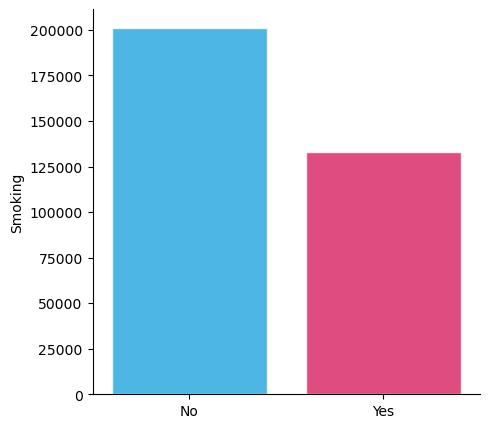

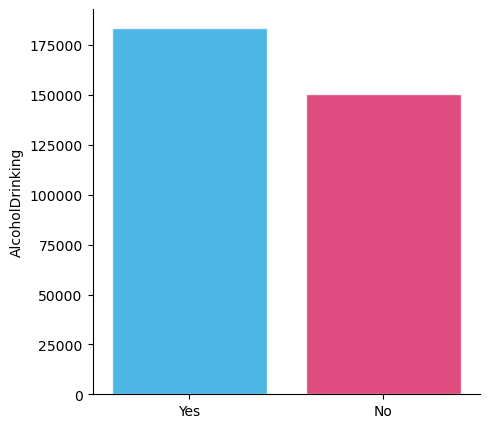

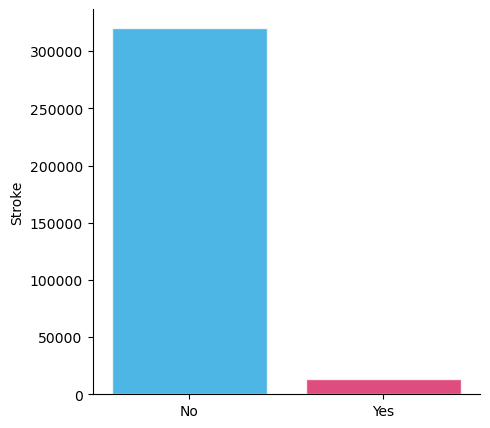

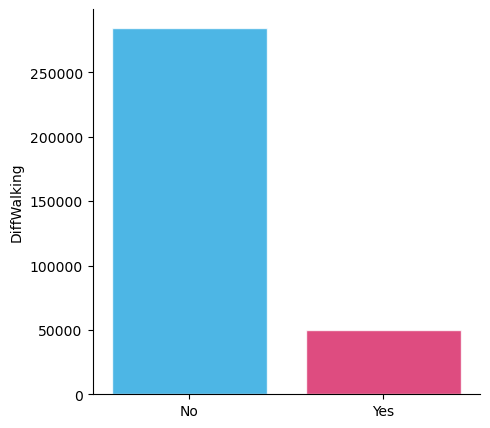

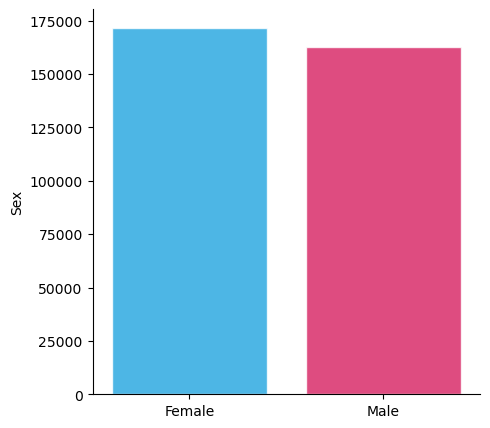

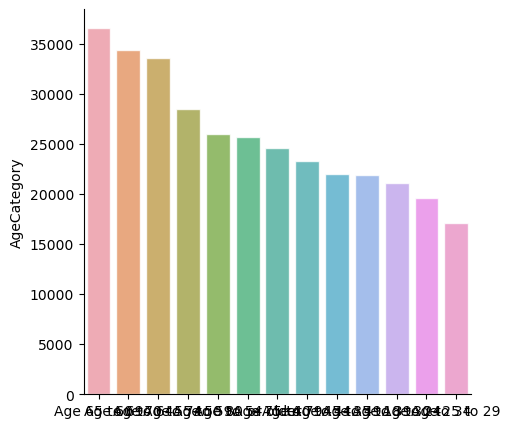

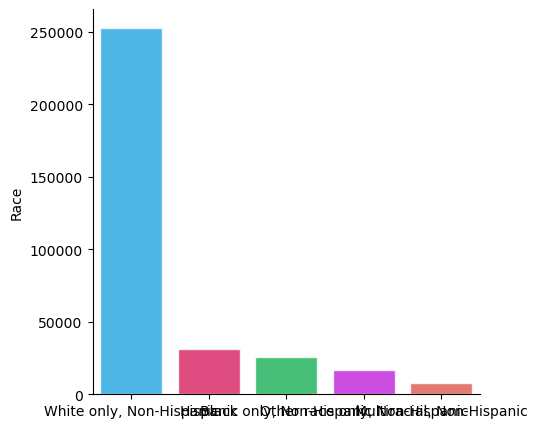

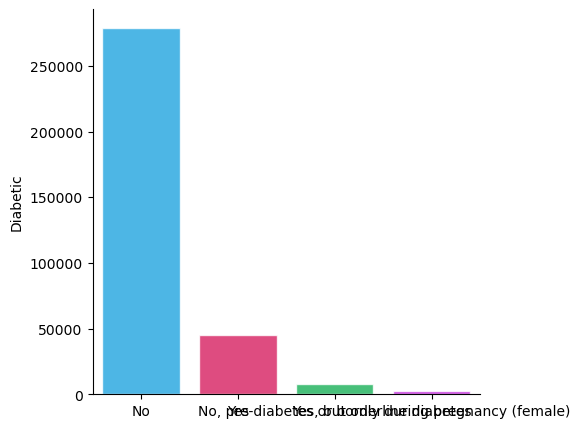

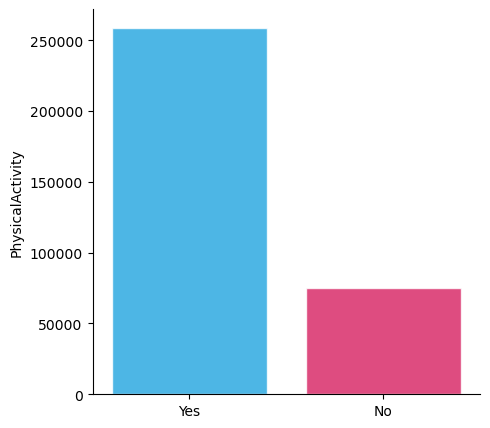

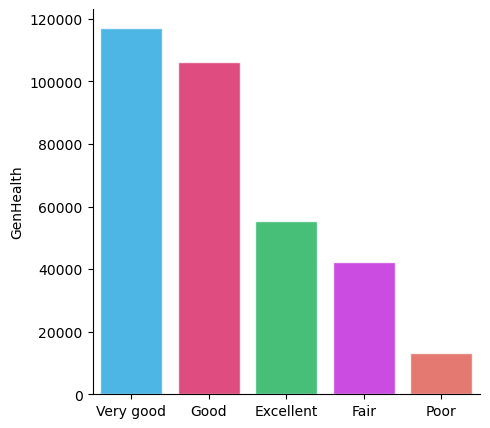

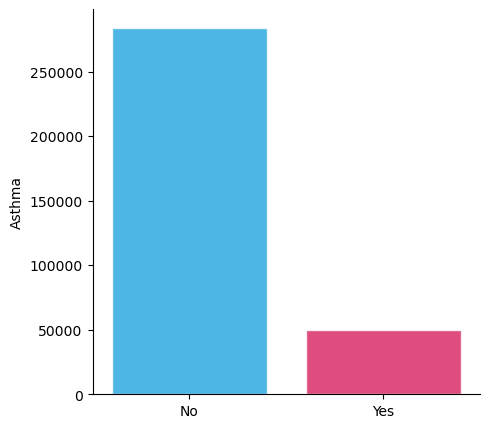

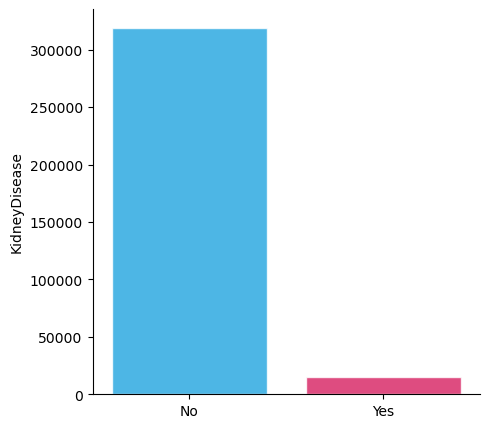

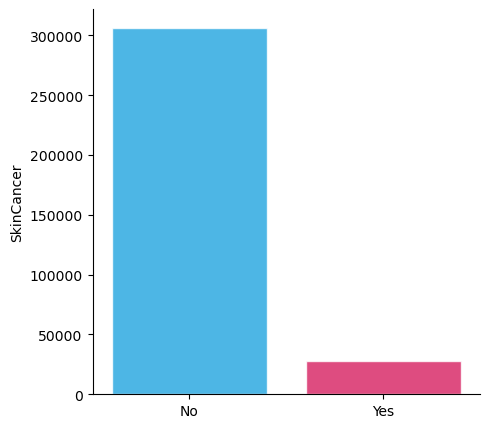

In [106]:
for i in cat_list:
    plt.subplots(figsize=(5, 5))
    frequent = df[i].value_counts()
    sns.barplot(y=frequent.values,x =frequent.index, orient='v',alpha=0.8,order=frequent.index)
    plt.ylabel(i)
    plt.show()

plt.show()

In [107]:
# Boolean check for missing values
df.isnull().any()

HeartDisease        False
BMI                 False
Smoking             False
AlcoholDrinking     False
Stroke              False
PhysicalHealth      False
MentalHealth        False
DiffWalking         False
Sex                 False
AgeCategory         False
Race                False
Diabetic            False
PhysicalActivity    False
GenHealth           False
SleepTime           False
Asthma              False
KidneyDisease       False
SkinCancer          False
dtype: bool

In [108]:
Dup = df.duplicated().sum()
Dup_ratio = (100*Dup/len(df)).round(3)
print(f'The percentage of duplicated data is {Dup_ratio} %')
df.duplicated().sum()

The percentage of duplicated data is 3.237 %


10823

In [109]:
df.drop_duplicates(inplace=True)
df.shape

(323498, 18)

In [110]:
for i in df.columns:
    if df[i].dtype == type(object):
        print(i,end=': ')
        print('\n',df[i].unique())
        print()

HeartDisease: 
 ['No' 'Yes']

Smoking: 
 ['No' 'Yes']

AlcoholDrinking: 
 ['No' 'Yes']

Stroke: 
 ['No' 'Yes']

DiffWalking: 
 ['No' 'Yes']

Sex: 
 ['Female' 'Male']

AgeCategory: 
 ['Age 80 or older' 'Age 55 to 59' 'Age 40 to 44' 'Age 70 to 74'
 'Age 65 to 69' 'Age 60 to 64' 'Age 75 to 79' 'Age 50 to 54'
 'Age 45 to 49' 'Age 35 to 39' 'Age 30 to 34' 'Age 25 to 29'
 'Age 18 to 24']

Race: 
 ['White only, Non-Hispanic' 'Black only, Non-Hispanic'
 'Other race only, Non-Hispanic' 'Multiracial, Non-Hispanic' 'Hispanic']

Diabetic: 
 ['No' 'Yes' 'No, pre-diabetes or borderline diabetes'
 'Yes, but only during pregnancy (female)']

PhysicalActivity: 
 ['No' 'Yes']

GenHealth: 
 ['Excellent' 'Very good' 'Fair' 'Poor' 'Good']

Asthma: 
 ['No' 'Yes']

KidneyDisease: 
 ['No' 'Yes']

SkinCancer: 
 ['Yes' 'No']



In [111]:
# Import label encoder
from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
df['HeartDisease']= label_encoder.fit_transform(df['HeartDisease'])
df['Smoking']= label_encoder.fit_transform(df['Smoking'])
df['AlcoholDrinking']= label_encoder.fit_transform(df['AlcoholDrinking'])
df['Stroke']= label_encoder.fit_transform(df['Stroke'])
df['DiffWalking']= label_encoder.fit_transform(df['DiffWalking'])
df['Sex']= label_encoder.fit_transform(df['Sex'])
df['AgeCategory']= label_encoder.fit_transform(df['AgeCategory'])
df['Race']= label_encoder.fit_transform(df['Race'])
df['Diabetic']= label_encoder.fit_transform(df['Diabetic'])
df['PhysicalActivity']= label_encoder.fit_transform(df['PhysicalActivity'])
df['GenHealth']= label_encoder.fit_transform(df['GenHealth'])
df['Asthma']= label_encoder.fit_transform(df['Asthma'])
df['KidneyDisease']= label_encoder.fit_transform(df['KidneyDisease'])
df['SkinCancer']= label_encoder.fit_transform(df['SkinCancer'])

In [112]:
df

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,26.57,0,0,0,0.0,0.0,0,0,12,4,0,0,0,6.0,0,0,1
1,0,25.61,0,0,0,2.0,3.0,0,0,7,4,0,1,4,5.0,0,0,1
2,0,21.77,0,1,0,2.0,0.0,0,0,4,4,0,1,1,9.0,0,0,0
3,0,26.08,0,0,1,1.0,0.0,0,1,12,4,2,0,3,7.0,0,0,0
4,0,22.96,1,1,0,0.0,0.0,0,0,12,0,0,1,4,7.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334315,0,24.34,0,0,0,0.0,7.0,0,0,1,0,0,1,1,7.0,0,0,0
334316,0,29.86,0,1,1,0.0,15.0,0,1,9,2,2,1,2,7.0,0,0,0
334318,0,28.66,0,0,0,2.0,2.0,0,0,6,0,0,1,0,7.0,0,0,0
334319,0,32.55,0,0,0,0.0,0.0,0,1,10,0,0,0,4,5.0,1,0,0


<Axes: >

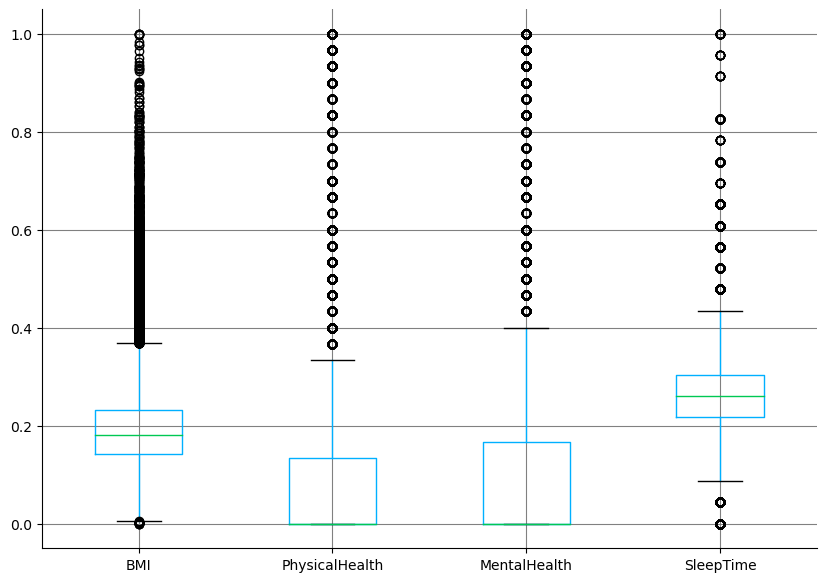

In [135]:
# Normalizing data
from sklearn.preprocessing import MinMaxScaler
'''
scaler = MinMaxScaler()
columns = df.columns
d = scaler.fit_transform(df)

scaled_df = pd.DataFrame(d, columns=columns)


scaled_df'''

# Normalize the continuous features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']])

# Add the normalized features to the dataframe
scaled_df = pd.DataFrame(scaled_features, columns=['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime'], index=df.index)
scaled_df
scaled_df.boxplot(column=cont_list, figsize=(10,7))


In [114]:
# Splitting the data into training (90%) and testing (10%) sets
# Adding evaluation

from sklearn.model_selection import train_test_split
train, test = train_test_split(scaled_df, test_size = 0.1, random_state=32,stratify=scaled_df['HeartDisease'])


x_train = train.drop(columns=['HeartDisease'],axis=1)
y_train = train['HeartDisease'].values

x_test = test.drop(columns=['HeartDisease'],axis=1)
y_test = test['HeartDisease'].values

the number of instance in the training data set is 291148
Among of them, the number of patient who has heart disease is 18022
Among of them, the number of patient who does not have heart disease is 273126
The number of instance in the testing data set is 32350
Before undersampling & oversampling: Counter({0: 303474, 1: 20024})


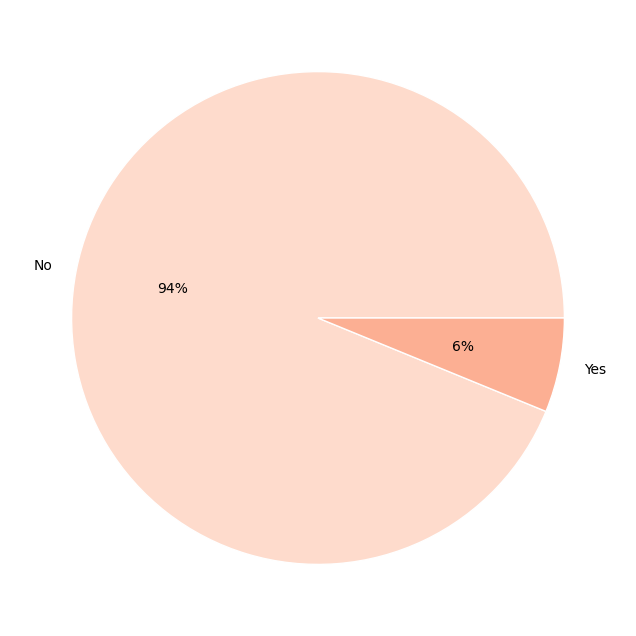

In [115]:
unique, counts = np.unique(y_train, return_counts=True)
print("the number of instance in the training data set is" ,len(y_train))
print("Among of them, the number of patient who has heart disease is", counts[1])
print("Among of them, the number of patient who does not have heart disease is", counts[0])
print("The number of instance in the testing data set is" ,len(y_test))
print(f'Before undersampling & oversampling: {Counter(df["HeartDisease"])}')
plt.pie(counts, labels = ['No', 'Yes'],colors= sns.color_palette('Reds'),autopct='%.0f%%')
plt.show()

Based on the result above, we could see that there is an imbalance in the training dataset (6% "Yes" class and 94% "No" class)

After undersampling: Counter({0.0: 36044, 1.0: 18022})


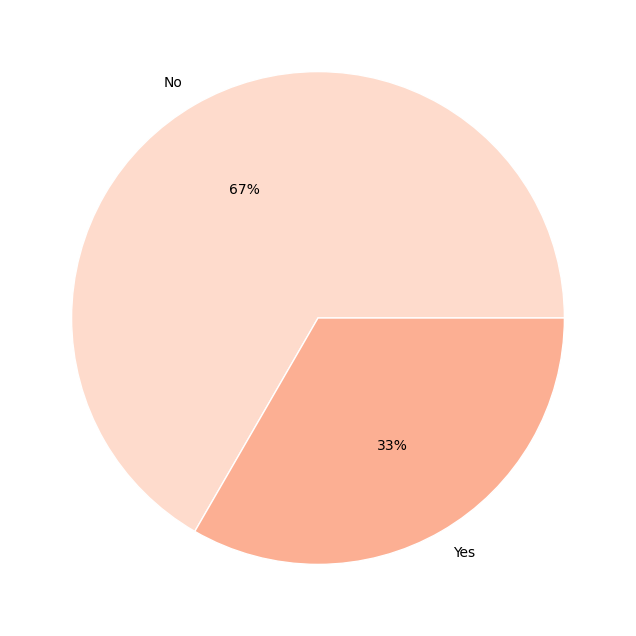

In [116]:
under_sampler = RandomUnderSampler(sampling_strategy=0.5)
x = x_train.iloc[:, 0:]
y = y_train
x_under, y_under = under_sampler.fit_resample(x, y)
print(f'After undersampling: {Counter(y_under)}')
unique_under, counts_under = np.unique(y_under, return_counts=True)

plt.pie(counts_under, labels = ['No', 'Yes'], colors = sns.color_palette('Reds'), autopct='%.0f%%');

Now we have a better dataset for training and evaluating our hyperparameters

In [117]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
from sklearn.model_selection import GridSearchCV
parameters = {
          'learning_rate': [0.1, 0.01],
          'max_depth': range(2,5),
          'objective':['binary:logistic'],
          'base_score': [0.25,0.5,0.75]
          }
clf = GridSearchCV(
    estimator=xgb_model,
    param_grid=parameters
)

clf.fit(x_under, y_under)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'base_score': [0.25, 0.5, 0.75],
                         'learning_rate': [0.1, 0.01], 'max_depth': range(2, 5),
                         'objective': ['binary:logistic']})

In [118]:
clf.cv_results_

{'mean_fit_time': array([0.22805853, 0.35917702, 0.33023982, 0.21539869, 0.27732258,
        0.3673224 , 0.25721207, 0.35903363, 0.38246255, 0.26600895,
        0.32762012, 0.35998416, 0.240762  , 0.33750291, 0.34612727,
        0.28328271, 0.33259511, 0.34440861]),
 'std_fit_time': array([0.01740672, 0.05810106, 0.03319952, 0.02580906, 0.02939098,
        0.05390413, 0.03972243, 0.03052909, 0.0632103 , 0.04635862,
        0.05150512, 0.07217727, 0.04492659, 0.04797514, 0.05536885,
        0.11009542, 0.0323345 , 0.05989062]),
 'mean_score_time': array([0.00486808, 0.02809706, 0.00553079, 0.00476484, 0.00551639,
        0.00522051, 0.00397758, 0.00520921, 0.00615621, 0.00483408,
        0.00487061, 0.00517197, 0.00535154, 0.00641298, 0.00667791,
        0.00587273, 0.00520062, 0.00655117]),
 'std_score_time': array([0.00083984, 0.04593373, 0.00043189, 0.00057818, 0.00132144,
        0.00033915, 0.0003669 , 0.0005734 , 0.0007726 , 0.00070982,
        0.00125032, 0.00040854, 0.00132545, 

In [119]:
!pip install sklearn-evaluation

<Axes: title={'center': 'Grid search results'}, xlabel='base_score', ylabel='Mean score'>

<Figure size 1500x800 with 0 Axes>

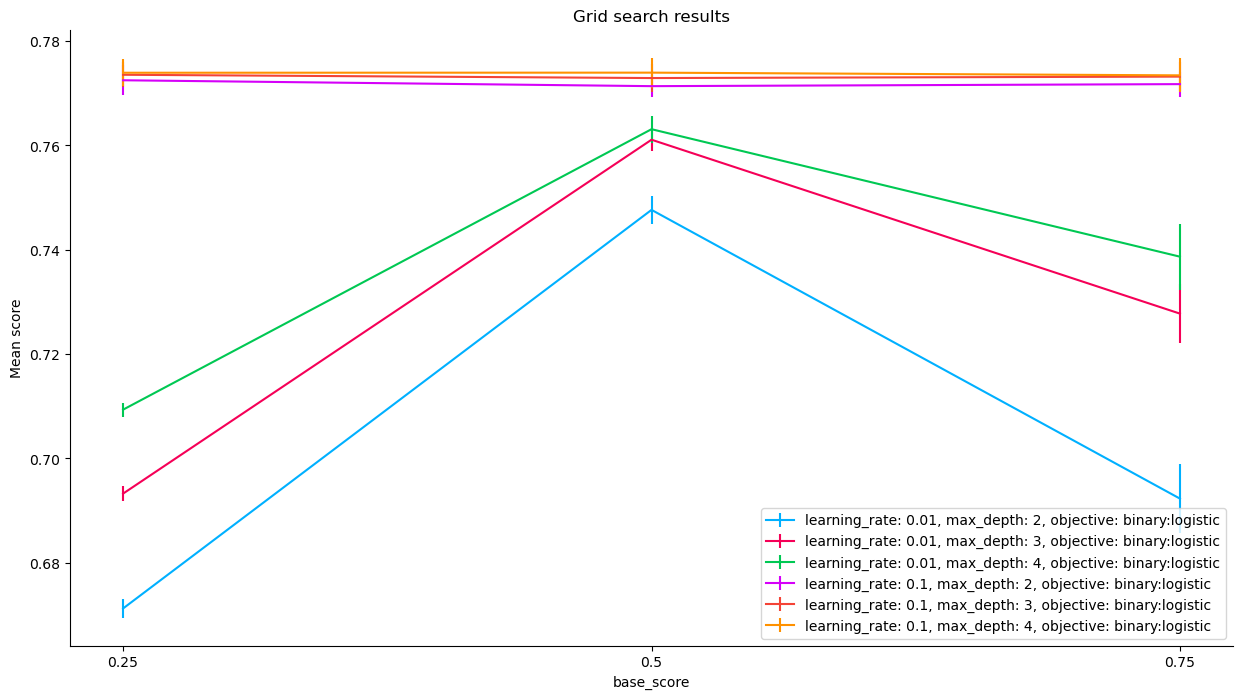

In [120]:
from sklearn_evaluation import plot
from sklearn_evaluation.plot import grid_search
plt.figure(figsize=(15,8))
grid_search(clf.cv_results_, change='base_score')

In [121]:
print("Due to GridSearchCV, we found the best setting hyperparameter as follow:", clf.best_params_)
print("In our undersampled training data, we got the best score after 5 fold of training process:", clf.best_score_)


Due to GridSearchCV, we found the best setting hyperparameter as follow: {'base_score': 0.5, 'learning_rate': 0.1, 'max_depth': 4, 'objective': 'binary:logistic'}
In our undersampled training data, we got the best score after 5 fold of training process: 0.7739429781374579


0.8285625965996909


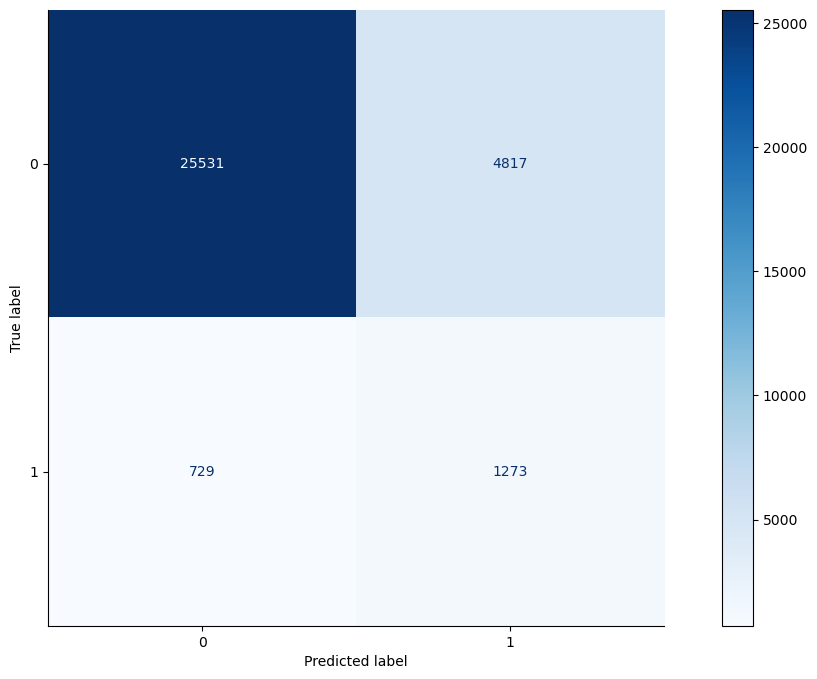

In [122]:
y_pred= clf.predict(x_test)

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
accuracy = accuracy_score(y_test,y_pred)
print(accuracy)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

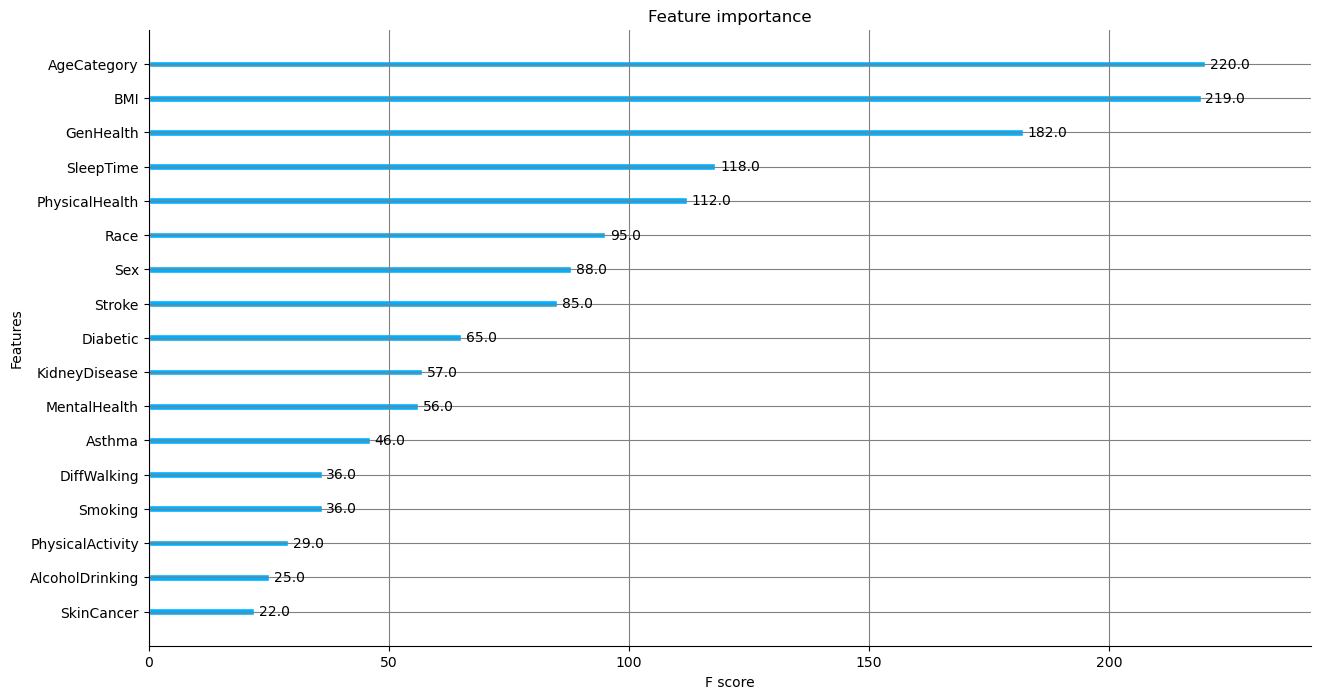

In [123]:
from xgboost import plot_importance
plt.rcParams["figure.figsize"] = (15, 8)
plot_importance(clf.best_estimator_, max_num_features=25)

As we can see from feature important report, the 3 least important feature are "PhysicalActivity", "SkinCancer", and "AlcoholDrinking." Let's remove them and retrain the model.

Accuracy of the model after cut out the least important features: 0.8270170015455951
Confusion matrix of the model after cut out the least important features:


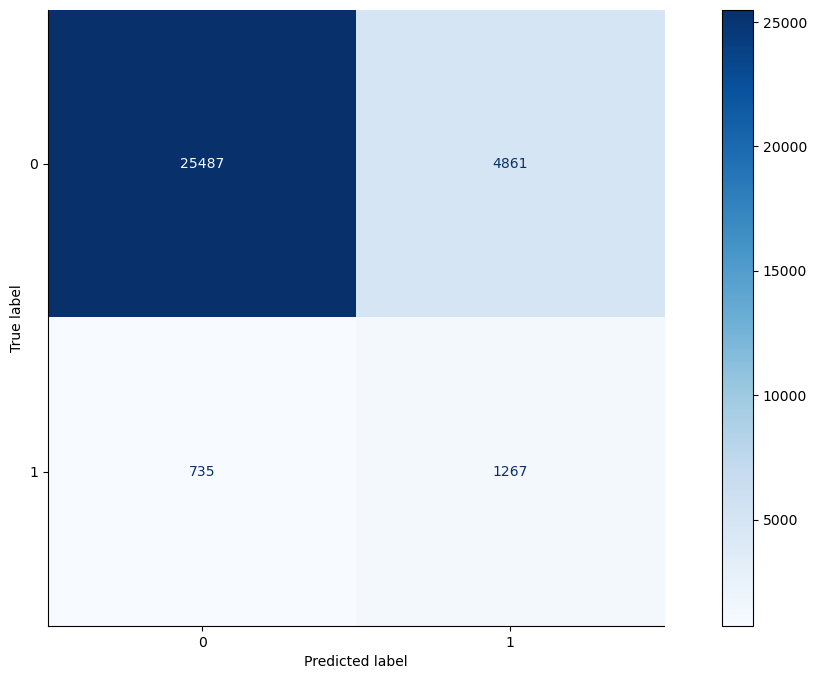

In [124]:
xgb_model1 = XGBClassifier(base_score =0.25, learning_rate =0.1, max_depth =4);
xgb_model1.fit(x_under.drop(columns=["PhysicalActivity", "SkinCancer", "AlcoholDrinking"]), y_under);
xgb_model1_pred = xgb_model1.predict(x_test.drop(columns=["PhysicalActivity", "SkinCancer", "AlcoholDrinking"]))

xgb_model1_matrix = confusion_matrix(y_test, xgb_model1_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=xgb_model1_matrix)
xgb_model1_acc = accuracy_score(y_test,xgb_model1_pred)
print("Accuracy of the model after cut out the least important features:", xgb_model1_acc)
disp.plot(cmap="Blues")
print("Confusion matrix of the model after cut out the least important features:")
plt.show()

As we can see, the accuracy is sightly decrease after we remove 3 features.

We now are going to compare this to another model: Logitistic regression and ID3 decision tree

Accuracy of the ID3 decision tree model 0.7540340030911901
Confusion matrix of the ID3 decision tree:


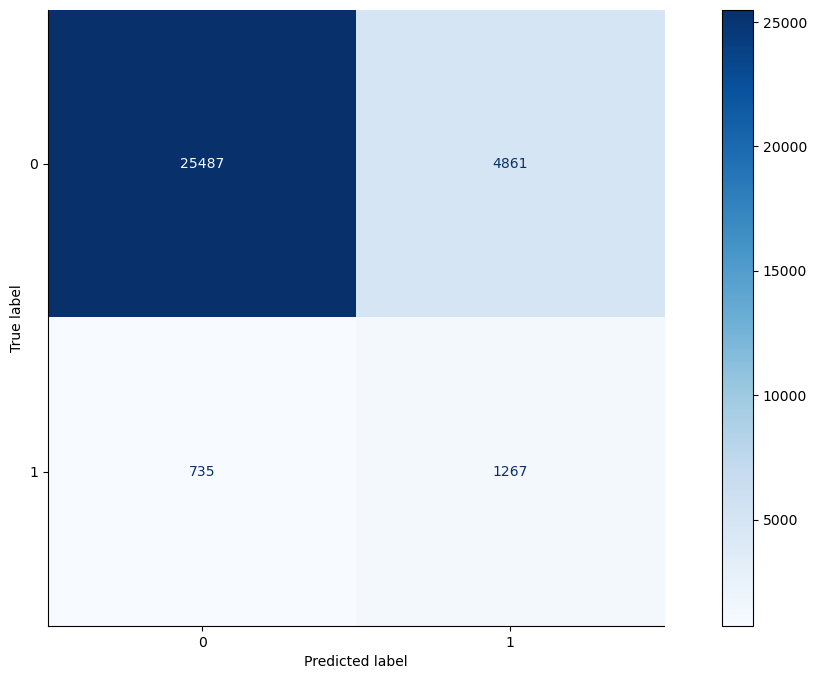

In [125]:
from sklearn import tree
model_ID3 = tree.DecisionTreeClassifier(criterion='entropy')
model_ID3.fit(x_under,y_under)
model_ID3_pred = model_ID3.predict(x_test)
model_ID3_acc = accuracy_score(y_test, model_ID3_pred)
model_ID3_matrix = confusion_matrix(y_test, model_ID3_pred, labels=[0, 1])
disp_ID3 = ConfusionMatrixDisplay(confusion_matrix=model_ID3_matrix)
print("Accuracy of the ID3 decision tree model", model_ID3_acc)
disp.plot(cmap="Blues")
print("Confusion matrix of the ID3 decision tree:")
plt.show()

Accuracy of the logistic regression model 0.8464296754250387
Confusion matrix of the logistic regression:


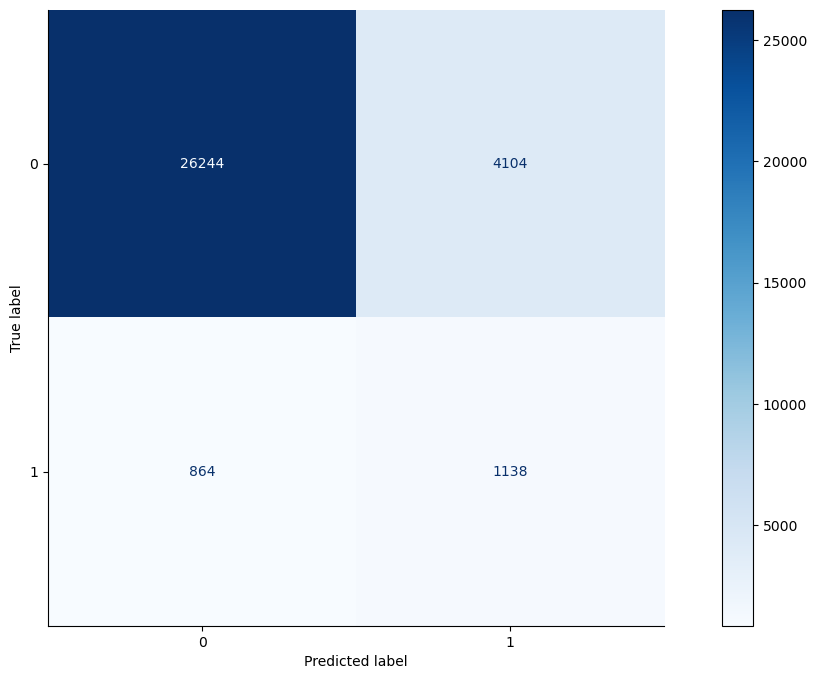

In [126]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(x_under,y_under)
model_logi_pred=logreg.predict(x_test)
model_logi_pred = logreg.predict(x_test)
model_logi_acc = accuracy_score(y_test, model_logi_pred)
logi_matrix = confusion_matrix(y_test, model_logi_pred, labels=[0, 1])
logi_matrix_dis = ConfusionMatrixDisplay(confusion_matrix=logi_matrix)
print("Accuracy of the logistic regression model", model_logi_acc)
logi_matrix_dis.plot(cmap="Blues")
print("Confusion matrix of the logistic regression:")
plt.show()

Accuracy of the ID3 decision tree model 0.8464296754250387
Confusion matrix of the ID3 decision tree:


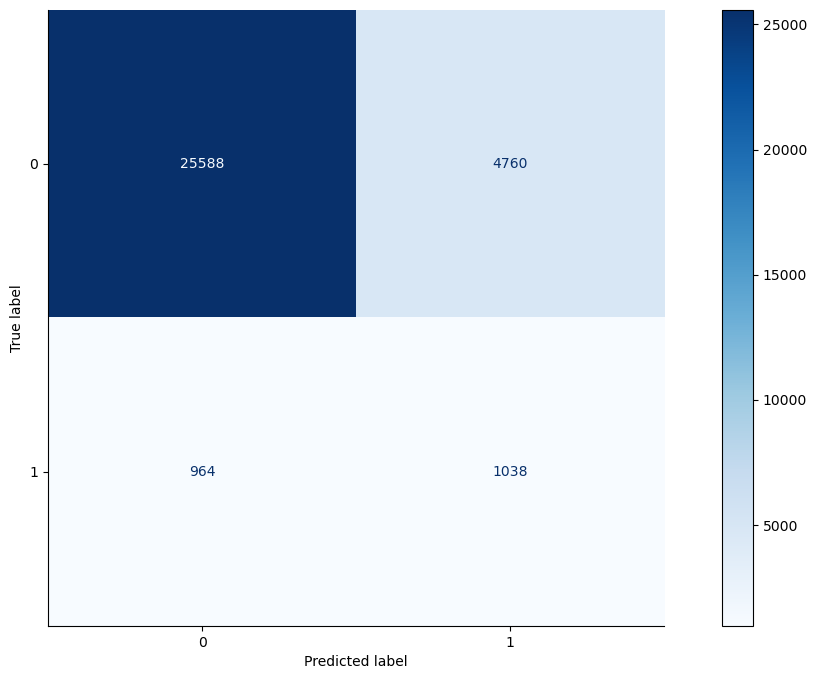

In [127]:
from sklearn.ensemble import RandomForestClassifier
Rf = RandomForestClassifier(n_estimators = 10, random_state=0)
Rf.fit(x_under, y_under)
Rf_pred = Rf.predict(x_test)
Rf_matrix = confusion_matrix(y_test, Rf_pred, labels=[0, 1])
Rf_acc = accuracy_score(y_test, model_logi_pred)
Rf_matrix_dis = ConfusionMatrixDisplay(confusion_matrix=Rf_matrix)
print("Accuracy of the ID3 decision tree model", Rf_acc)
Rf_matrix_dis.plot(cmap="Blues")
print("Confusion matrix of the ID3 decision tree:")
plt.show()